# Libraries

In [1]:
from Functions.func import NPZDatasetManager,ClassDistributionPlotter,BalancedDatasetSampler
from Functions.func import generate_dataset_info,visualize_image_channels,plot_multiclass_roc,plot_confusion_matrices
from Functions.func import DatasetSplitter,ImageTransformer,TrainingPlotter
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Add, Activation
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Adagrad, SGD
from tensorflow.keras.metrics import Precision, Recall, AUC, TopKCategoricalAccuracy
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import l2

## Manage the Data

In [2]:
manager = NPZDatasetManager("Data")

Number of .npz files in the path: 3
Data/Jet Image 7 100p 0 10000.npz
Data/jetImage_7_100p_40000_50000.npz
Data/Jet Image 10000-20000.npz


In [3]:
my_dataset = manager.load_npz_by_index(0)
(my_dataset['jetClass'])

Keys in the NPZ file: ['jetImage', 'jetClass']


array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [13]:
#load the x and y del dataset
var_x = my_dataset['jetImage']
var_y = my_dataset['jetClass']
plotter = ClassDistributionPlotter(var_y)

In [14]:
#First create a Dictionary for the data
#dict of particle
particles = {
    "gluons": [1, 0, 0, 0, 0],
    "quarks": [0, 1, 0, 0, 0],
    "Ws":     [0, 0, 1, 0, 0],
    "Zs":     [0, 0, 0, 1, 0],
    "tops":   [0, 0, 0, 0, 1]
}
particle_dict = {
    "gluons": 0,
    "quarks": 1,
    "Ws":     2,
    "Zs":     3,
    "tops":   4
}

class_names = ["Gluons", "Quarks", "Ws", "Zs", "Tops"]

/Users/bryphy/U/ML jet tag/JetTag/Functions/func.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  xytext=(0, 9),


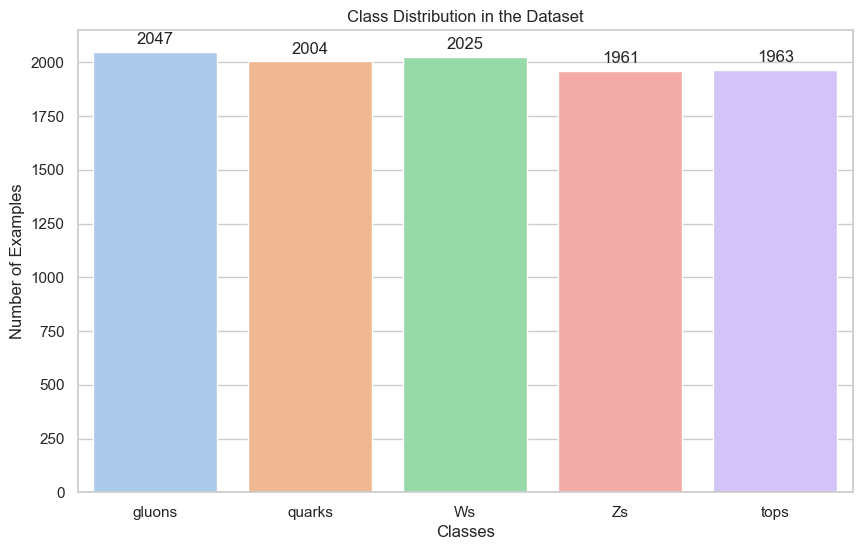

In [15]:

# Create an instance of the ClassDistributionPlotter
plotter = ClassDistributionPlotter(var_y)
# Map labels to class names
plotter.map_labels(particle_dict)
# Plot the distribution
plotter.plot_distribution()


## Balanced Data

/Users/bryphy/U/ML jet tag/JetTag/Functions/func.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  xytext=(0, 9),


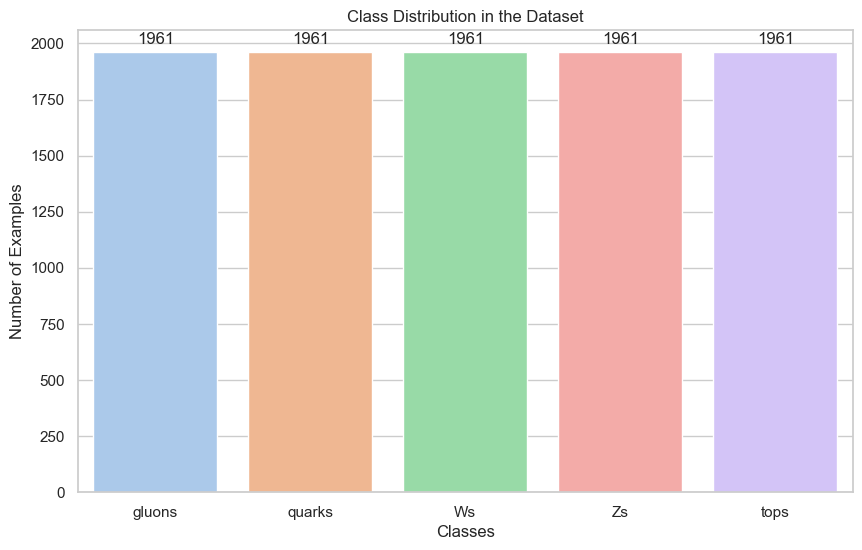

In [16]:
balanced_sampler = BalancedDatasetSampler(var_x, var_y)
balanced_sampler.balance_dataset(shuffle=False)
images = balanced_sampler.balanced_images
labels = balanced_sampler.balanced_labels

plotter = ClassDistributionPlotter(labels)
# Map labels to class names
plotter.map_labels(particle_dict)
# Plot the distribution
plotter.plot_distribution()

In [17]:
info_result = generate_dataset_info(images, labels)
print(info_result)

Length of images: 9805
Shape of images: (9805, 100, 100)
Shape of the first element of images: (100, 100)
Length of labels: 9805
Shape of labels: (9805, 5)
Shape of the first element of labels: (5,)


## Checkig Dimensionality

In [20]:

# Check if expanding the dimensions of the images is necessary
if images.ndim == 3:
    # Add a third axis for the channel
    images = np.expand_dims(images, axis=-1)

In [21]:
info_result = generate_dataset_info(images, labels)
print(info_result)

Length of images: 9805
Shape of images: (9805, 100, 100, 1)
Shape of the first element of images: (100, 100, 1)
Length of labels: 9805
Shape of labels: (9805, 5)
Shape of the first element of labels: (5,)


In [22]:
splitter = DatasetSplitter(train_size=0.7, val_size=0.15, test_size=0.15)
splits = splitter.split_data(images, labels)

Dimensions of the training set:  (6863, 100, 100, 1)
Dimensions of the validation set:  (1471, 100, 100, 1)
Dimensions of the test set:  (1471, 100, 100, 1)


## Apply Tranformations ( if is necessary)

In [27]:
transformation_lay = []


In [28]:
transformer = ImageTransformer()

In [29]:
X_train_transformed, y_train_transformed = transformer.apply_transformset(splits['X_train'], splits['y_train'],
                                                              transformation_list= transformation_lay,
                                                              normalize_function=True,
                                                              apply_fft=False,
                                                              )


In [30]:
X_train_transformed_info = generate_dataset_info(X_train_transformed.numpy(),
                                                 y_train_transformed.numpy())
print(X_train_transformed_info)

Length of images: 6863
Shape of images: (6863, 100, 100, 1)
Shape of the first element of images: (100, 100, 1)
Length of labels: 6863
Shape of labels: (6863, 5)
Shape of the first element of labels: (5,)


In [31]:

X_val_transformed, y_val_transformed = transformer.apply_transformset(splits['X_val'], splits['y_val'],
                                                             transformation_list= transformation_lay,

                                                                      normalize_function=True,
                                                              apply_fft=False)

In [32]:
X_val_transformed_info = generate_dataset_info(X_val_transformed.numpy(),
                                               y_val_transformed.numpy(),
                                               )
print(X_val_transformed_info)

Length of images: 1471
Shape of images: (1471, 100, 100, 1)
Shape of the first element of images: (100, 100, 1)
Length of labels: 1471
Shape of labels: (1471, 5)
Shape of the first element of labels: (5,)


In [33]:

X_test_transformed, y_test_transformed = transformer.apply_transformset(splits['X_test'], splits['y_test'],
                                                              #transformation_list= transformation_lay, --> is not't necesary for test data
                                                              normalize_function=True,
                                                              apply_fft=False)


In [34]:


X_test_transformed_info = generate_dataset_info(X_test_transformed.numpy(),
                                               y_test_transformed.numpy()
                                               )
print(X_test_transformed_info)

Length of images: 1471
Shape of images: (1471, 100, 100, 1)
Shape of the first element of images: (100, 100, 1)
Length of labels: 1471
Shape of labels: (1471, 5)
Shape of the first element of labels: (5,)


## Buildind Data loaders

In [35]:

n_batch= 128
train_loader = tf.data.Dataset.from_tensor_slices((X_train_transformed, y_train_transformed)).shuffle(buffer_size=len(X_train_transformed)).batch(n_batch)
val_loader = tf.data.Dataset.from_tensor_slices((X_val_transformed, y_val_transformed)).batch(n_batch)
test_loader = tf.data.Dataset.from_tensor_slices((X_test_transformed, y_test_transformed)).batch(n_batch)

In [36]:

def print_batch_shapes(loader, data_type):
    for X, y in loader:
        print(f"#--- {data_type} batch's shapes---------------")
        print(f"Shape of X [N,  H, W ,C]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

print_batch_shapes(train_loader, "Training")
print_batch_shapes(val_loader, "Validation")
print_batch_shapes(test_loader, "Testing")

#--- Training batch's shapes---------------
Shape of X [N,  H, W ,C]: (128, 100, 100, 1)
Shape of y: (128, 5) <dtype: 'float32'>
#--- Validation batch's shapes---------------
Shape of X [N,  H, W ,C]: (128, 100, 100, 1)
Shape of y: (128, 5) <dtype: 'float32'>
#--- Testing batch's shapes---------------
Shape of X [N,  H, W ,C]: (128, 100, 100, 1)
Shape of y: (128, 5) <dtype: 'float32'>


## Verify the transformations per Data Loader

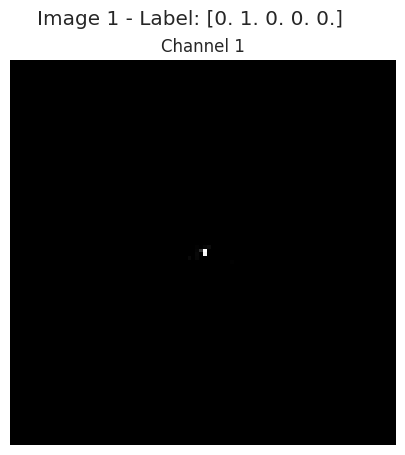

Min pixel value in channel 1: 0.0
Max pixel value in channel 1: 0.27463436126708984
Channel 1 is correctly normalized


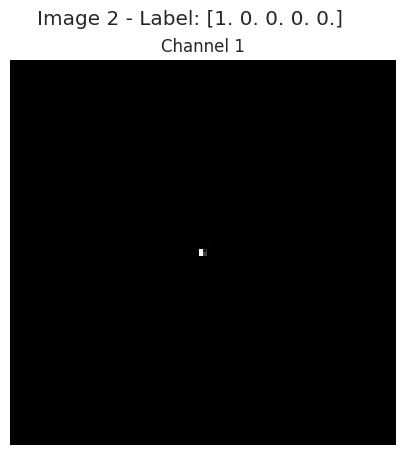

Min pixel value in channel 1: 0.0
Max pixel value in channel 1: 0.4314141571521759
Channel 1 is correctly normalized


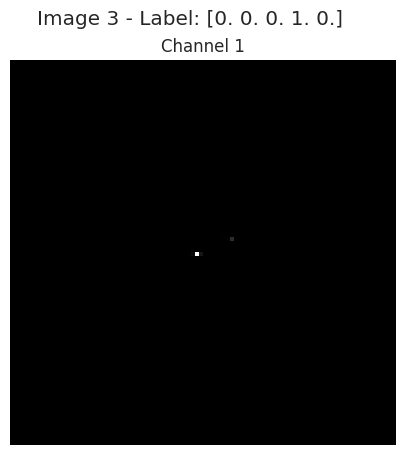

Min pixel value in channel 1: 0.0
Max pixel value in channel 1: 0.5903521180152893
Channel 1 is correctly normalized


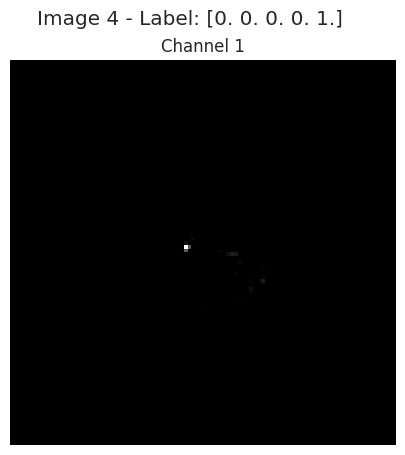

Min pixel value in channel 1: 0.0
Max pixel value in channel 1: 0.24768845736980438
Channel 1 is correctly normalized


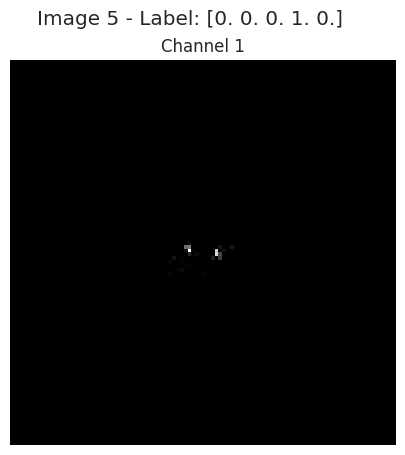

Min pixel value in channel 1: 0.0
Max pixel value in channel 1: 0.12945707142353058
Channel 1 is correctly normalized


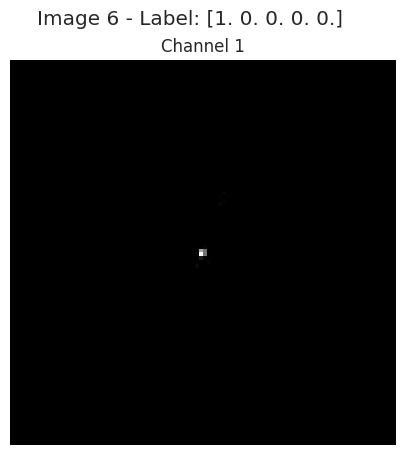

Min pixel value in channel 1: 0.0
Max pixel value in channel 1: 0.22804823517799377
Channel 1 is correctly normalized


In [37]:

for images, labels in train_loader.take(1):
    visualize_image_channels(images, labels, num_images=6)

# Building Models


##Model 1

In [ ]:


def create_simple_model(input_shape=(100, 100, 1), num_classes=5):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create the model
input_shape = (100, 100, 1)
num_classes = 5
model = create_simple_model(input_shape, num_classes)

# Display model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 98, 98, 32)        320       
                                                                 
 batch_normalization_16 (Ba  (None, 98, 98, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 49, 49, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_17 (Ba  (None, 47, 47, 64)       

In [ ]:

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/U/ML/Models/best_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

callbacks = [early_stopping, model_checkpoint, reduce_lr]



# Train the model
history = model.fit(train_loader,
                    epochs=50,
                    validation_data=val_loader,

                    callbacks=callbacks)

Epoch 1/50
54/54 [==============================] - 6s 79ms/step - loss: 1.9369 - accuracy: 0.4201 - val_loss: 2.0066 - val_accuracy: 0.2148 - lr: 0.0010
Epoch 2/50
54/54 [==============================] - 4s 67ms/step - loss: 1.5754 - accuracy: 0.4679 - val_loss: 2.1886 - val_accuracy: 0.1781 - lr: 0.0010
Epoch 3/50
54/54 [==============================] - 4s 65ms/step - loss: 1.4296 - accuracy: 0.5036 - val_loss: 2.3580 - val_accuracy: 0.1781 - lr: 0.0010
Epoch 4/50
54/54 [==============================] - 4s 66ms/step - loss: 1.3743 - accuracy: 0.5060 - val_loss: 2.4509 - val_accuracy: 0.1781 - lr: 0.0010
Epoch 5/50
54/54 [==============================] - 5s 88ms/step - loss: 1.3086 - accuracy: 0.5286 - val_loss: 2.6221 - val_accuracy: 0.1781 - lr: 0.0010
Epoch 6/50
54/54 [==============================] - 4s 75ms/step - loss: 1.2582 - accuracy: 0.5480 - val_loss: 3.0024 - val_accuracy: 0.1781 - lr: 0.0010
Epoch 7/50
54/54 [==============================] - 4s 76ms/step - loss: 1.2

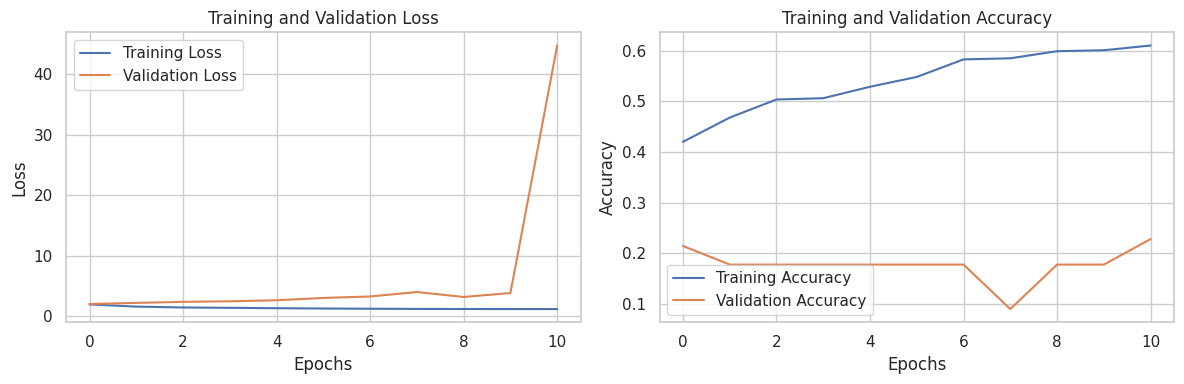

In [ ]:
plotter = TrainingPlotter(history)
plotter.plot_metrics()

## Model2

In [ ]:
def model2(input_shape=(100, 100, 1), num_classes=5):
    model = Sequential()


    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))#, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(64, (3, 3), activation='relu'))#, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))


    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))#, kernel_regularizer=l2(0.01)))



    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model
# Create the model
input_shape = (100, 100, 1)
num_classes = 5
model2 =model2(input_shape, num_classes)

# Display model summary
model2.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 98, 98, 32)        320       
                                                                 
 batch_normalization_19 (Ba  (None, 98, 98, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_20 (Ba  (None, 47, 47, 64)        256       
 tchNormalization)                                               
                                                      

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/U/ML/Models/best_model2.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

In [ ]:
history2 = model2.fit(train_loader,
                    epochs=50,
                    validation_data=val_loader,
                    callbacks=callbacks)

Epoch 1/50
54/54 [==============================] - 7s 56ms/step - loss: 1.4757 - accuracy: 0.4549 - val_loss: 1.9149 - val_accuracy: 0.1985 - lr: 5.0000e-04
Epoch 2/50
54/54 [==============================] - 3s 49ms/step - loss: 1.0752 - accuracy: 0.5792 - val_loss: 1.9894 - val_accuracy: 0.1985 - lr: 5.0000e-04
Epoch 3/50
54/54 [==============================] - 2s 42ms/step - loss: 0.9623 - accuracy: 0.6401 - val_loss: 1.9415 - val_accuracy: 0.1985 - lr: 5.0000e-04
Epoch 4/50
54/54 [==============================] - 3s 62ms/step - loss: 0.8673 - accuracy: 0.6869 - val_loss: 1.6825 - val_accuracy: 0.1985 - lr: 5.0000e-04
Epoch 5/50
54/54 [==============================] - 3s 51ms/step - loss: 0.7907 - accuracy: 0.7144 - val_loss: 2.0128 - val_accuracy: 0.1985 - lr: 5.0000e-04
Epoch 6/50
54/54 [==============================] - 3s 55ms/step - loss: 0.7325 - accuracy: 0.7379 - val_loss: 3.8186 - val_accuracy: 0.1985 - lr: 5.0000e-04
Epoch 7/50
54/54 [==============================] - 

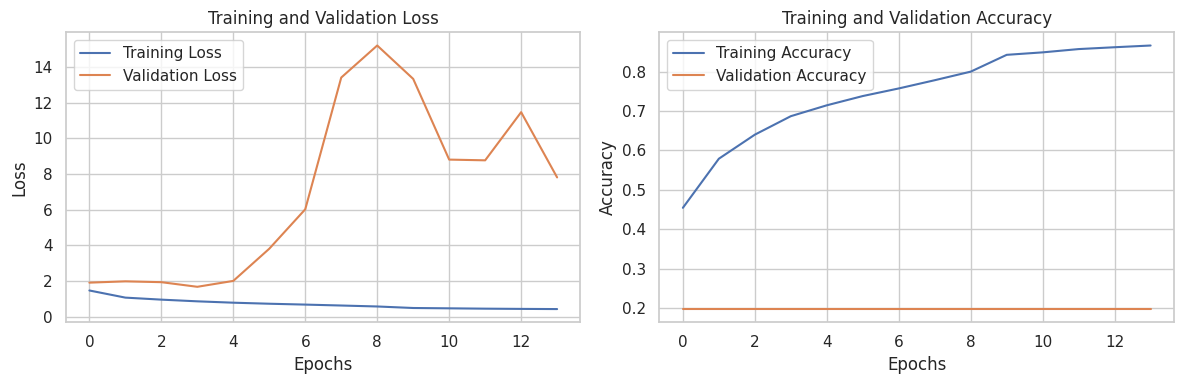

In [ ]:
plotter = TrainingPlotter(history2)
plotter.plot_metrics()

##Model 3

In [ ]:
def model3(input_shape=(100, 100, 1), num_classes=5):
    model = Sequential()


    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0005),  # Reducir la tasa de aprendizaje
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model
# Create the model
input_shape = (100, 100, 1)
num_classes = 5
model3 =model3(input_shape, num_classes)

# Display model summary
model3.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 batch_normalization_8 (Bat  (None, 98, 98, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 49, 49, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_9 (Bat  (None, 47, 47, 64)       

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('Models/best_model3.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

In [ ]:
history3 = model3.fit(train_loader,
                    epochs=50,
                    validation_data=val_loader,
                    callbacks=callbacks)

Epoch 1/50
54/54 [==============================] - 6s 76ms/step - loss: 3.2215 - accuracy: 0.4036 - val_loss: 2.6566 - val_accuracy: 0.1781 - lr: 5.0000e-04
Epoch 2/50
54/54 [==============================] - 4s 70ms/step - loss: 2.2652 - accuracy: 0.4399 - val_loss: 2.6680 - val_accuracy: 0.1985 - lr: 5.0000e-04
Epoch 3/50
54/54 [==============================] - 4s 74ms/step - loss: 2.0530 - accuracy: 0.4601 - val_loss: 2.5924 - val_accuracy: 0.1985 - lr: 5.0000e-04
Epoch 4/50
54/54 [==============================] - 4s 73ms/step - loss: 1.9509 - accuracy: 0.4728 - val_loss: 2.5843 - val_accuracy: 0.1781 - lr: 5.0000e-04
Epoch 5/50
54/54 [==============================] - 4s 76ms/step - loss: 1.8699 - accuracy: 0.4744 - val_loss: 2.5153 - val_accuracy: 0.1781 - lr: 5.0000e-04
Epoch 6/50
54/54 [==============================] - 4s 72ms/step - loss: 1.7874 - accuracy: 0.4865 - val_loss: 2.4977 - val_accuracy: 0.1781 - lr: 5.0000e-04
Epoch 7/50
54/54 [==============================] - 

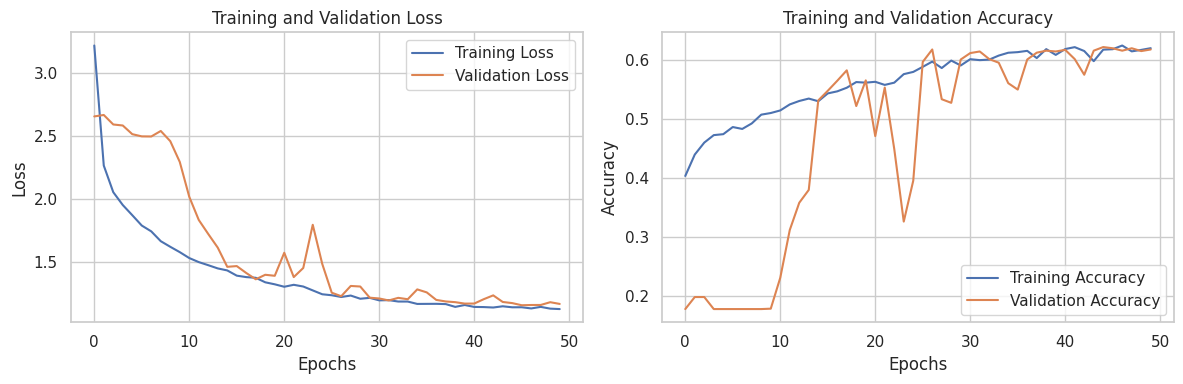

In [ ]:
plotter = TrainingPlotter(history3)
plotter.plot_metrics()

##Model 4

In [ ]:

def model4(input_shape=(100, 100, 1), num_classes=5):
    model = Sequential()



    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu',input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.02)))
    model.add(BatchNormalization())
    #model.add(Dropout(0.3))

    model.add(Dense(50, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    optimizer = SGD(learning_rate=0.00001)

    # Compile the model
    model.compile(optimizer=optimizer,  # Reducir la tasa de aprendizaje
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Crear el modelo con las capas de aumento de datos
input_shape = (100, 100, 1)
num_classes = 5
model4 = model4(input_shape, num_classes)

# Display model summary
model4.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 98, 98, 32)        320       
                                                                 
 batch_normalization_21 (Ba  (None, 98, 98, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 49, 49, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_22 (Ba  (None, 47, 47, 64)       

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/U/ML/Models/best_model4.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

In [ ]:
history4 = model4.fit(train_loader,
                    epochs=100,
                    validation_data=val_loader,
                    callbacks=callbacks)

Epoch 1/100
54/54 [==============================] - 7s 77ms/step - loss: 7.6540 - accuracy: 0.2054 - val_loss: 6.8564 - val_accuracy: 0.2257 - lr: 1.0000e-05
Epoch 2/100
54/54 [==============================] - 4s 66ms/step - loss: 7.5909 - accuracy: 0.2126 - val_loss: 6.8906 - val_accuracy: 0.1781 - lr: 1.0000e-05
Epoch 3/100
54/54 [==============================] - 4s 66ms/step - loss: 7.6030 - accuracy: 0.2155 - val_loss: 6.9323 - val_accuracy: 0.1781 - lr: 1.0000e-05
Epoch 4/100
54/54 [==============================] - 4s 69ms/step - loss: 7.6072 - accuracy: 0.2138 - val_loss: 6.9680 - val_accuracy: 0.1781 - lr: 1.0000e-05
Epoch 5/100
54/54 [==============================] - 4s 66ms/step - loss: 7.5786 - accuracy: 0.2186 - val_loss: 6.9958 - val_accuracy: 0.1781 - lr: 1.0000e-05
Epoch 6/100
54/54 [==============================] - 4s 66ms/step - loss: 7.5889 - accuracy: 0.2257 - val_loss: 7.0208 - val_accuracy: 0.1781 - lr: 1.0000e-05
Epoch 7/100
54/54 [===========================

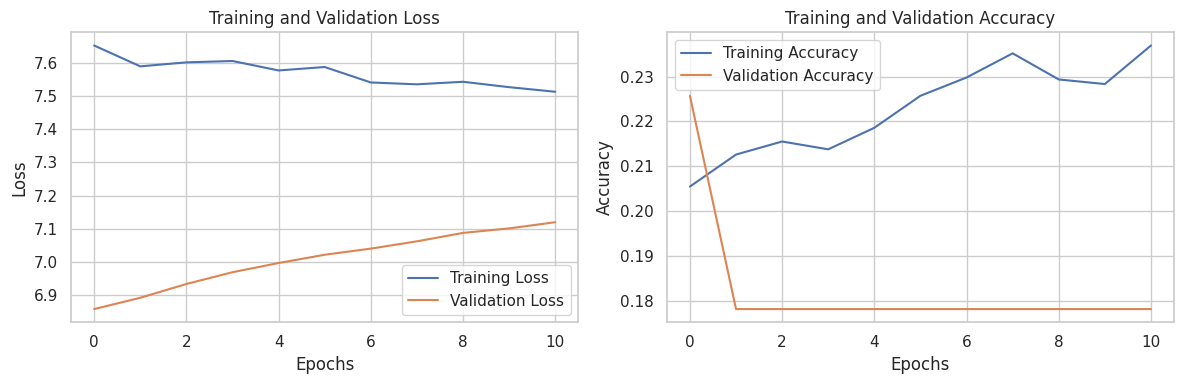

In [ ]:
plotter = TrainingPlotter(history4)
plotter.plot_metrics()

##Model5

In [ ]:

def residual_block(inputs, num_filters, kernel_size=(3, 3), strides=(1, 1), use_conv_shortcut=False):
    x = Conv2D(num_filters, kernel_size, strides=strides, padding='same', activation='relu')(inputs)
    x = Conv2D(num_filters, kernel_size, strides=strides, padding='same', activation='relu')(x)
    if use_conv_shortcut:
        identity = Conv2D(num_filters, (1, 1), strides=strides, padding='same')(inputs)
    else:
        identity = inputs
    x = Add()([x, identity])
    return x


def model5(input_shape=(100, 100, 1), dense1=256, dense2=128, num_classes=5):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(2, 2)(x)

    x = residual_block(x, 128, use_conv_shortcut=True)
    x = MaxPooling2D(2, 2)(x)

    x = residual_block(x, 256, use_conv_shortcut=True)
    x = MaxPooling2D(2, 2)(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(dense1, activation='relu')(x)
    x = Dense(dense2, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


input_shape = (100, 100, 1)
num_classes = 5
model5 = model5(input_shape=input_shape, dense1=256, dense2=128, num_classes=num_classes)


model5.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100, 100, 1)]        0         []                            
                                                                                                  
 conv2d_23 (Conv2D)          (None, 100, 100, 32)         320       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_19 (MaxPooli  (None, 50, 50, 32)           0         ['conv2d_23[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 50, 50, 128)          36992     ['max_pooling2d_19[0][0]

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/U/ML/Models/best_model5.keras', monitor='val_loss', save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

callbacks = [early_stopping, model_checkpoint, reduce_lr]
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
               loss='categorical_crossentropy',
               metrics=['accuracy'])


In [ ]:
history5 = model5.fit(train_loader,
                    epochs=100,
                    validation_data=val_loader,
                    callbacks=callbacks)

Epoch 1/100
54/54 [==============================] - 13s 186ms/step - loss: 1.4028 - accuracy: 0.4007 - val_loss: 1.2570 - val_accuracy: 0.5044 - lr: 5.0000e-04
Epoch 2/100
54/54 [==============================] - 10s 183ms/step - loss: 1.2315 - accuracy: 0.4903 - val_loss: 1.1918 - val_accuracy: 0.5343 - lr: 5.0000e-04
Epoch 3/100
54/54 [==============================] - 10s 188ms/step - loss: 1.1668 - accuracy: 0.5353 - val_loss: 1.1168 - val_accuracy: 0.5595 - lr: 5.0000e-04
Epoch 4/100
54/54 [==============================] - 10s 184ms/step - loss: 1.0929 - accuracy: 0.5712 - val_loss: 1.0485 - val_accuracy: 0.5874 - lr: 5.0000e-04
Epoch 5/100
54/54 [==============================] - 10s 183ms/step - loss: 1.0379 - accuracy: 0.5999 - val_loss: 1.0100 - val_accuracy: 0.6159 - lr: 5.0000e-04
Epoch 6/100
54/54 [==============================] - 10s 185ms/step - loss: 1.0263 - accuracy: 0.6050 - val_loss: 0.9751 - val_accuracy: 0.6315 - lr: 5.0000e-04
Epoch 7/100
54/54 [===============

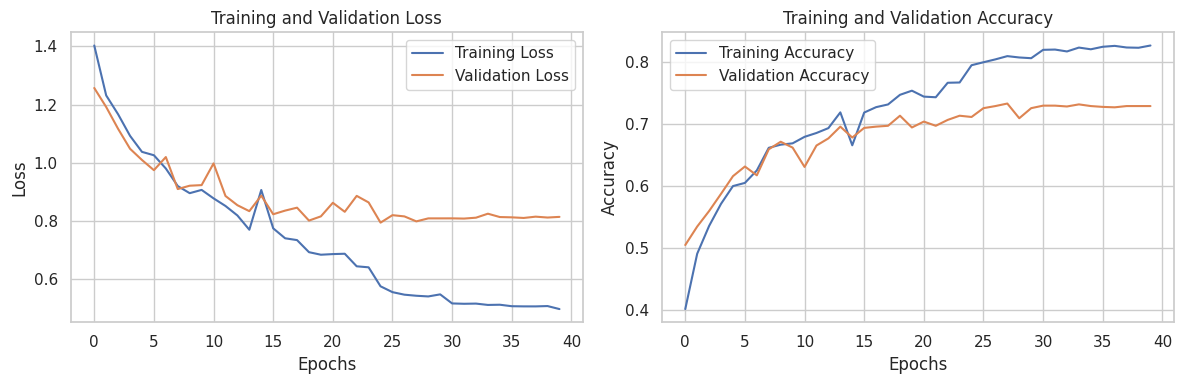

In [ ]:
plotter = TrainingPlotter(history5)
plotter.plot_metrics()

# Evaluate the models with  the metrics

In [ ]:
model1 = tf.keras.models.load_model('Models/best_model.keras')
model2 = tf.keras.models.load_model('Models/best_model2.keras')
model3 = tf.keras.models.load_model('Models/best_model4.keras')
model4 = tf.keras.models.load_model('Models/best_model4.keras')
model5 = tf.keras.models.load_model('Models/best_model5.keras')

## ROC Curves

46/46 [==============================] - 2s 31ms/step


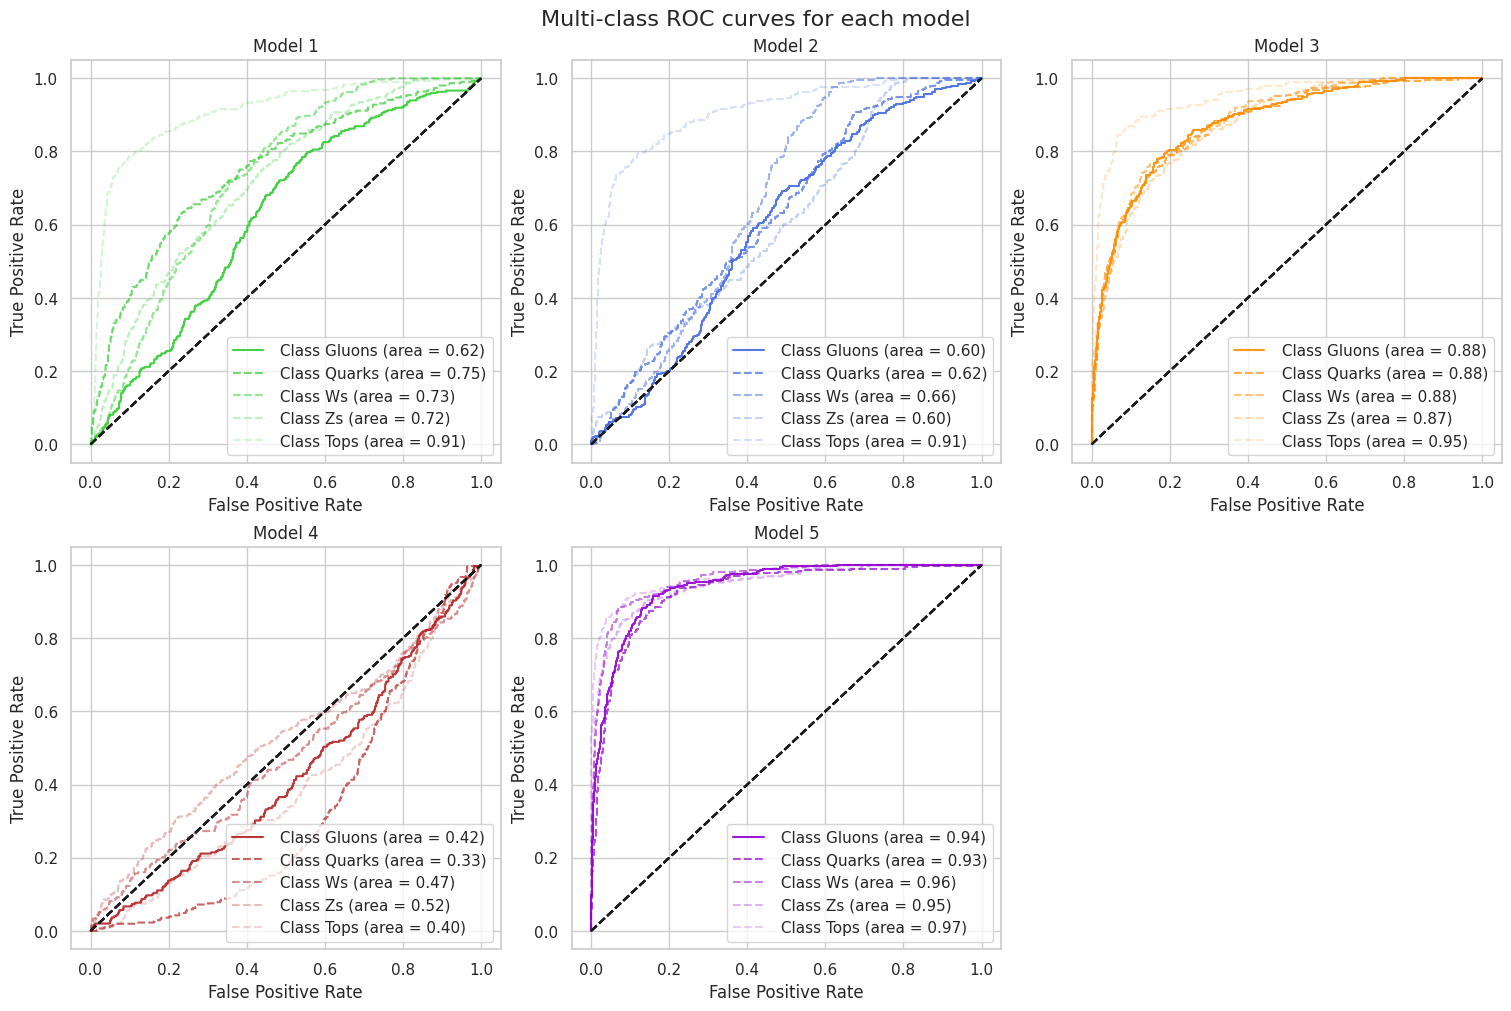

In [39]:
plot_multiclass_roc([model1,model2,model3,model4,model5,],
                    class_names=class_names ,
                    data= (X_test_transformed, y_test_transformed),
                    each=True)

46/46 [==============================] - 0s 5ms/step


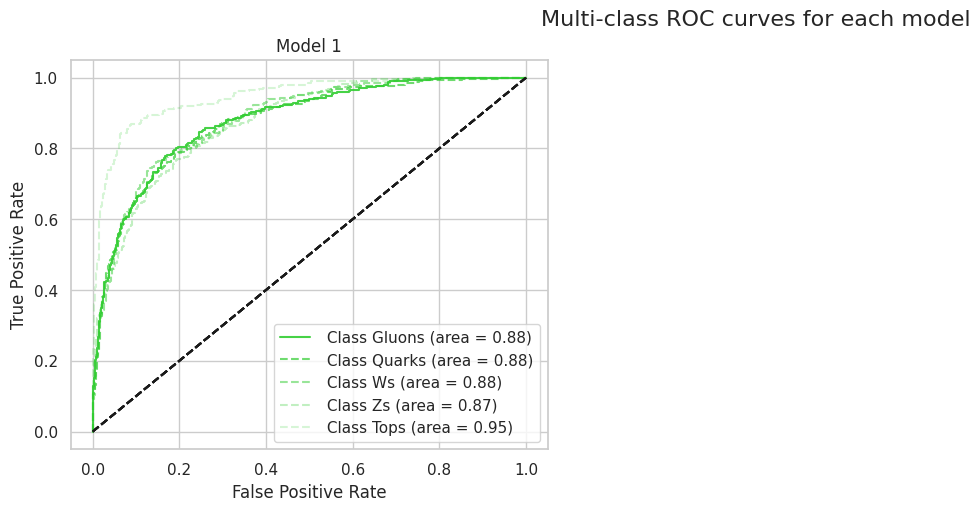

In [44]:
plot_multiclass_roc([model3],
                    class_names=class_names ,
                    data= (X_test_transformed, y_test_transformed),
                    each=True)

46/46 [==============================] - 1s 13ms/step


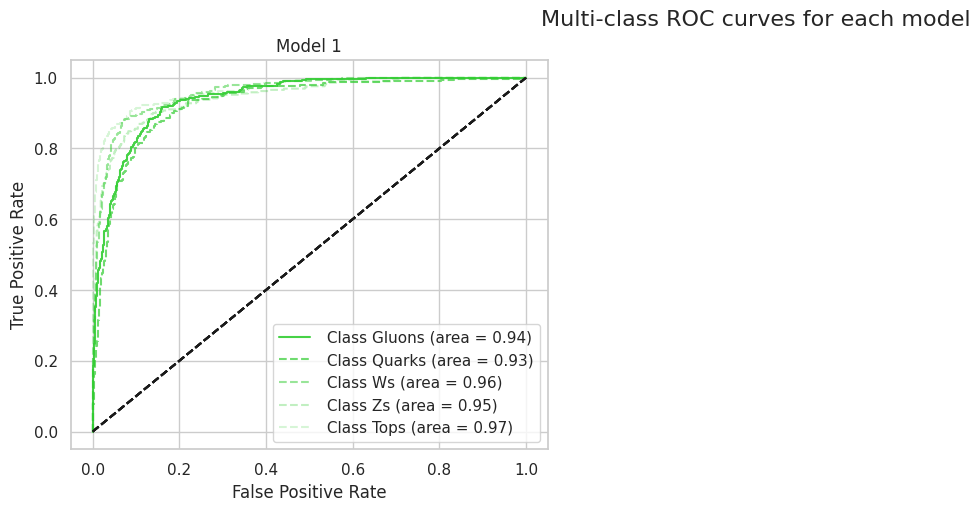

In [41]:
plot_multiclass_roc([model5],
                    class_names=class_names ,
                    data= (X_test_transformed, y_test_transformed),
                    each=True)

46/46 [==============================] - 0s 4ms/step


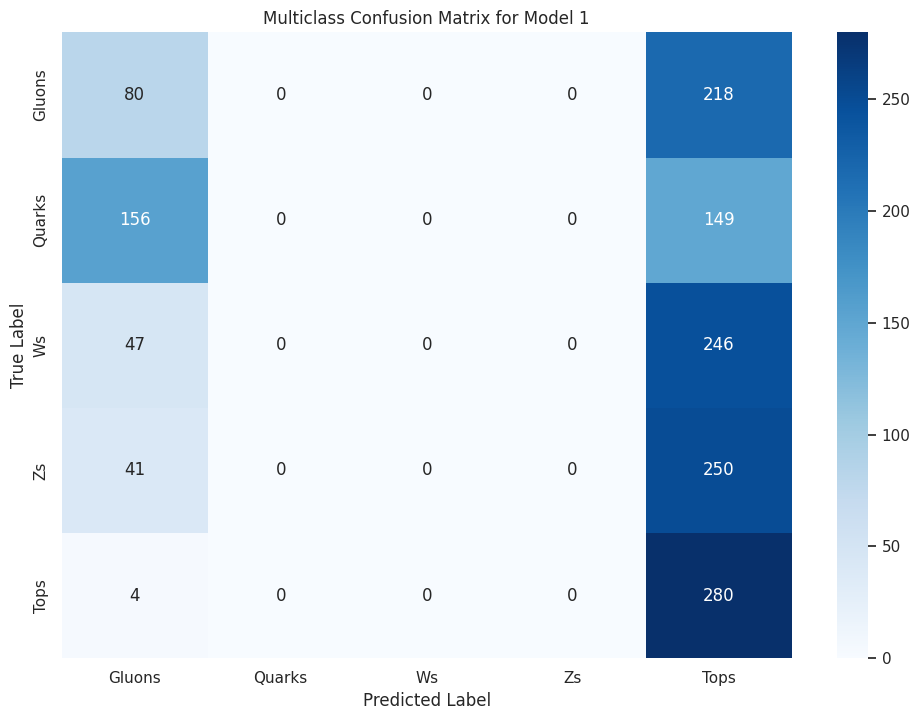

46/46 [==============================] - 1s 9ms/step


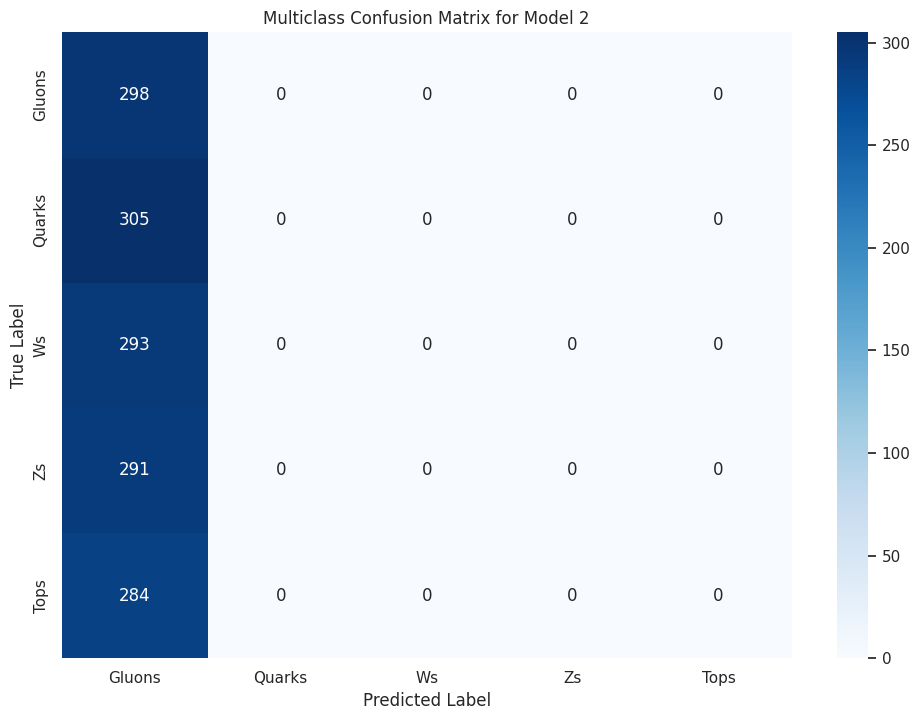

46/46 [==============================] - 0s 4ms/step


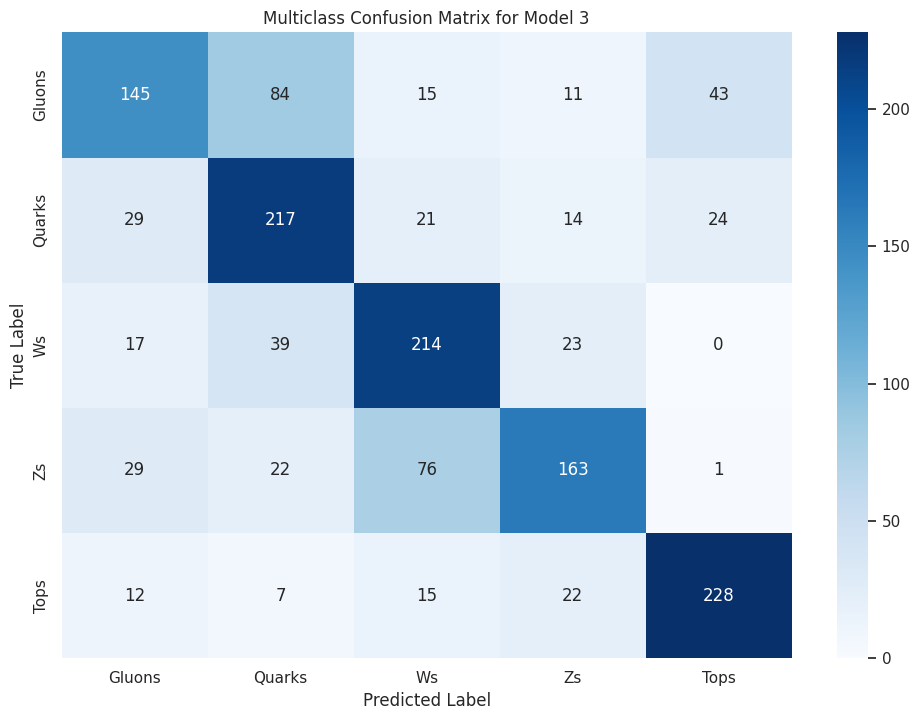

46/46 [==============================] - 0s 4ms/step


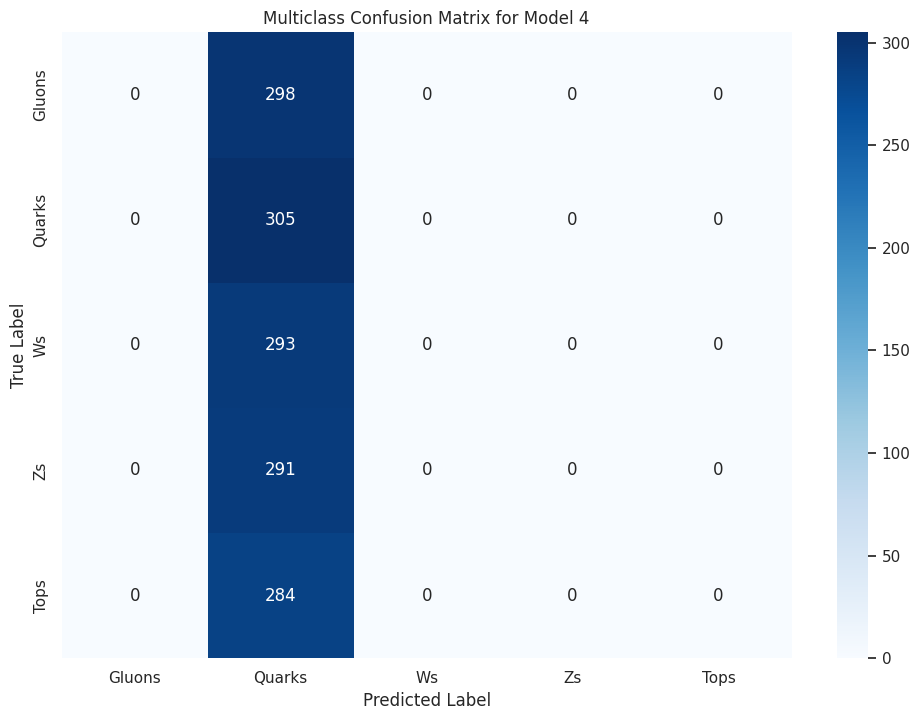

46/46 [==============================] - 1s 13ms/step


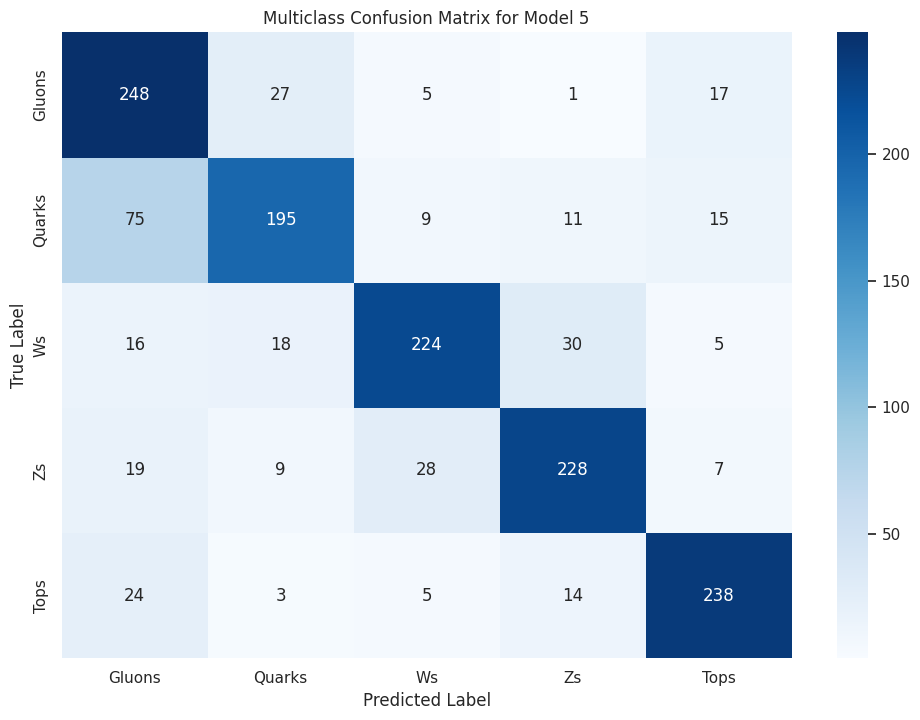

## Matrix Confusion

In [ ]:
plot_confusion_matrices([model1,model2,model3,model4,model5,],
                        class_names=class_names,
                        data= (X_test_transformed, y_test_transformed) ,)
                        #each = True)

46/46 [==============================] - 0s 5ms/step


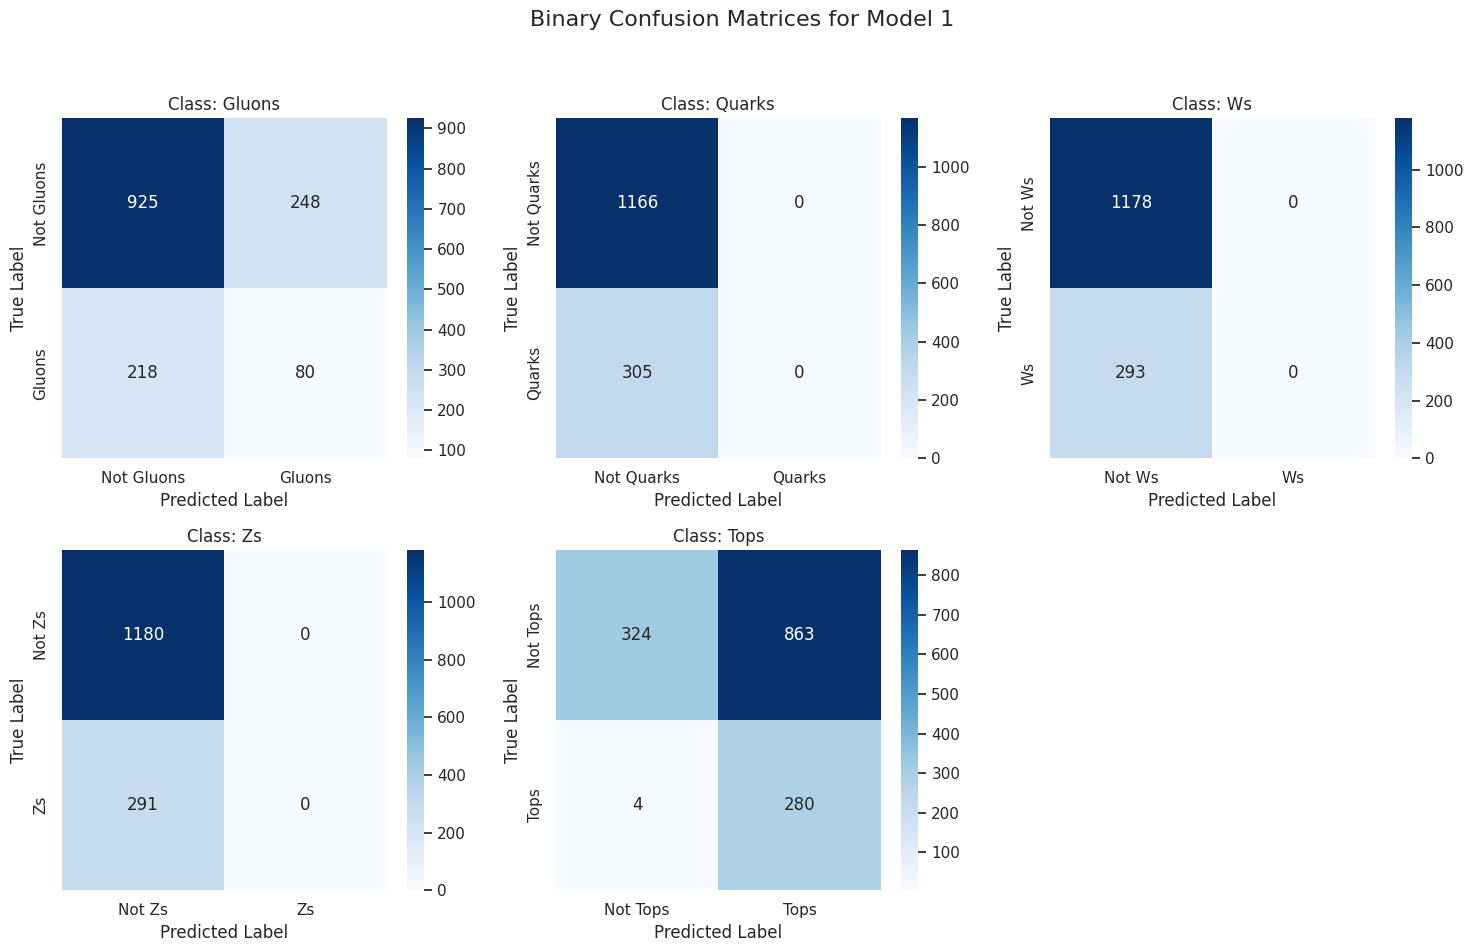

46/46 [==============================] - 0s 4ms/step


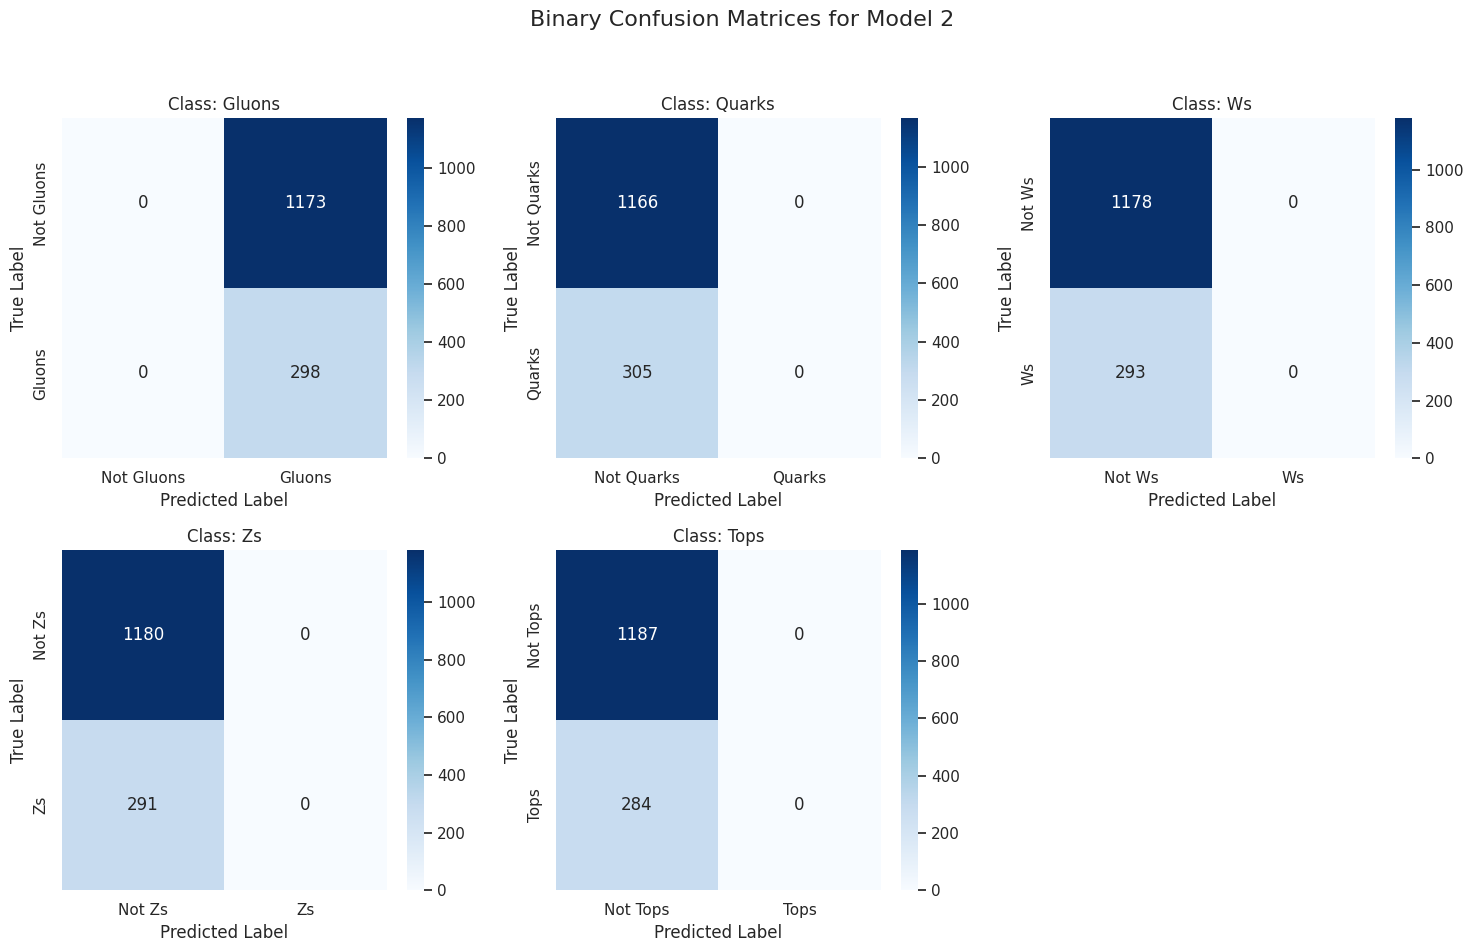

46/46 [==============================] - 0s 5ms/step


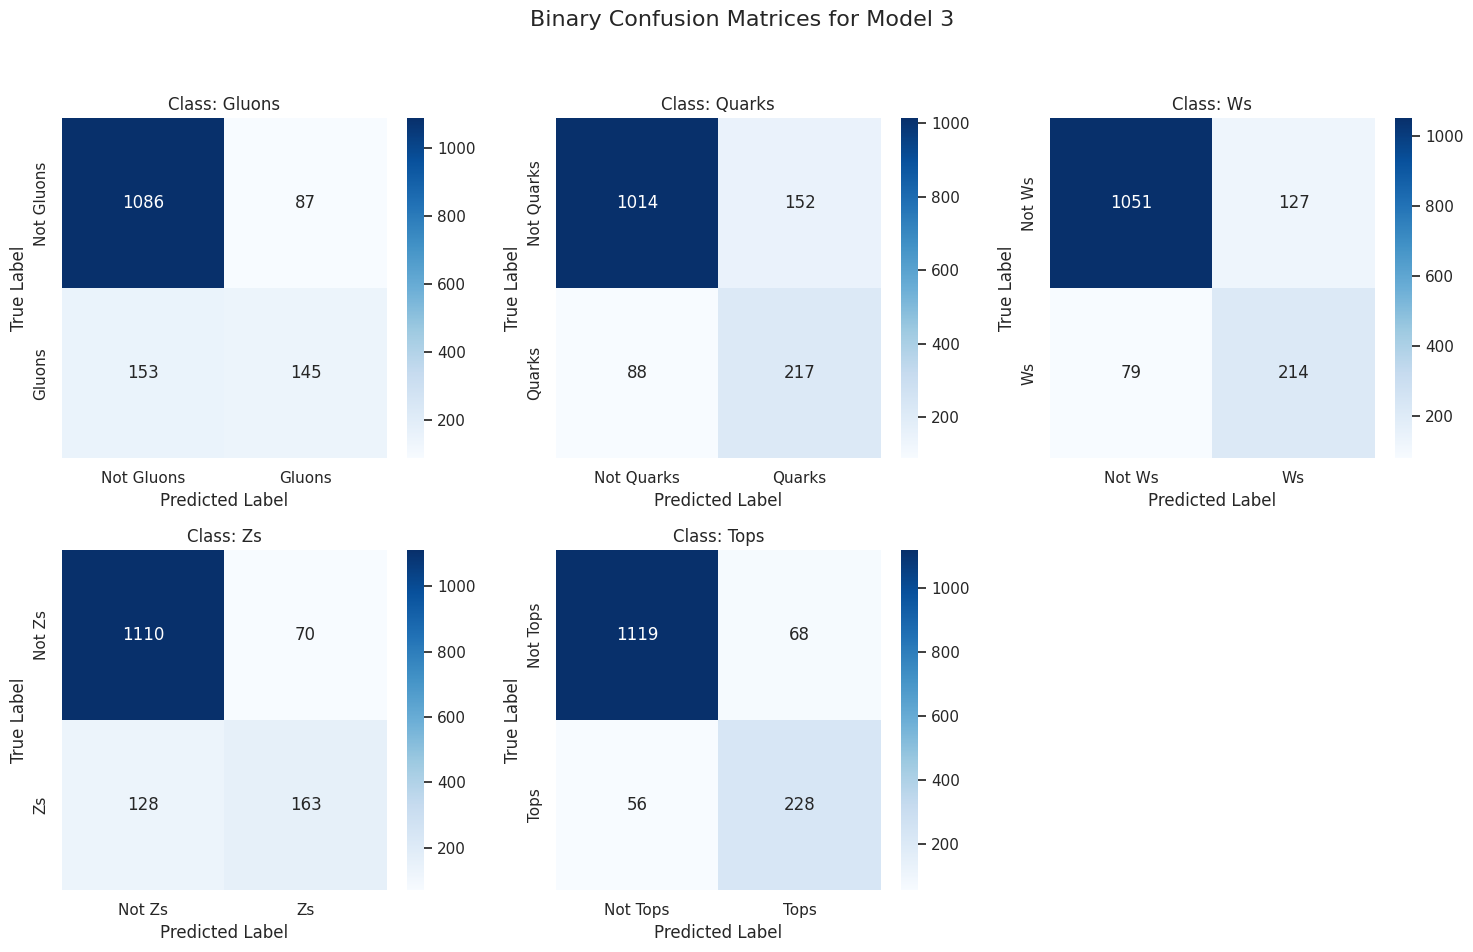

46/46 [==============================] - 0s 4ms/step


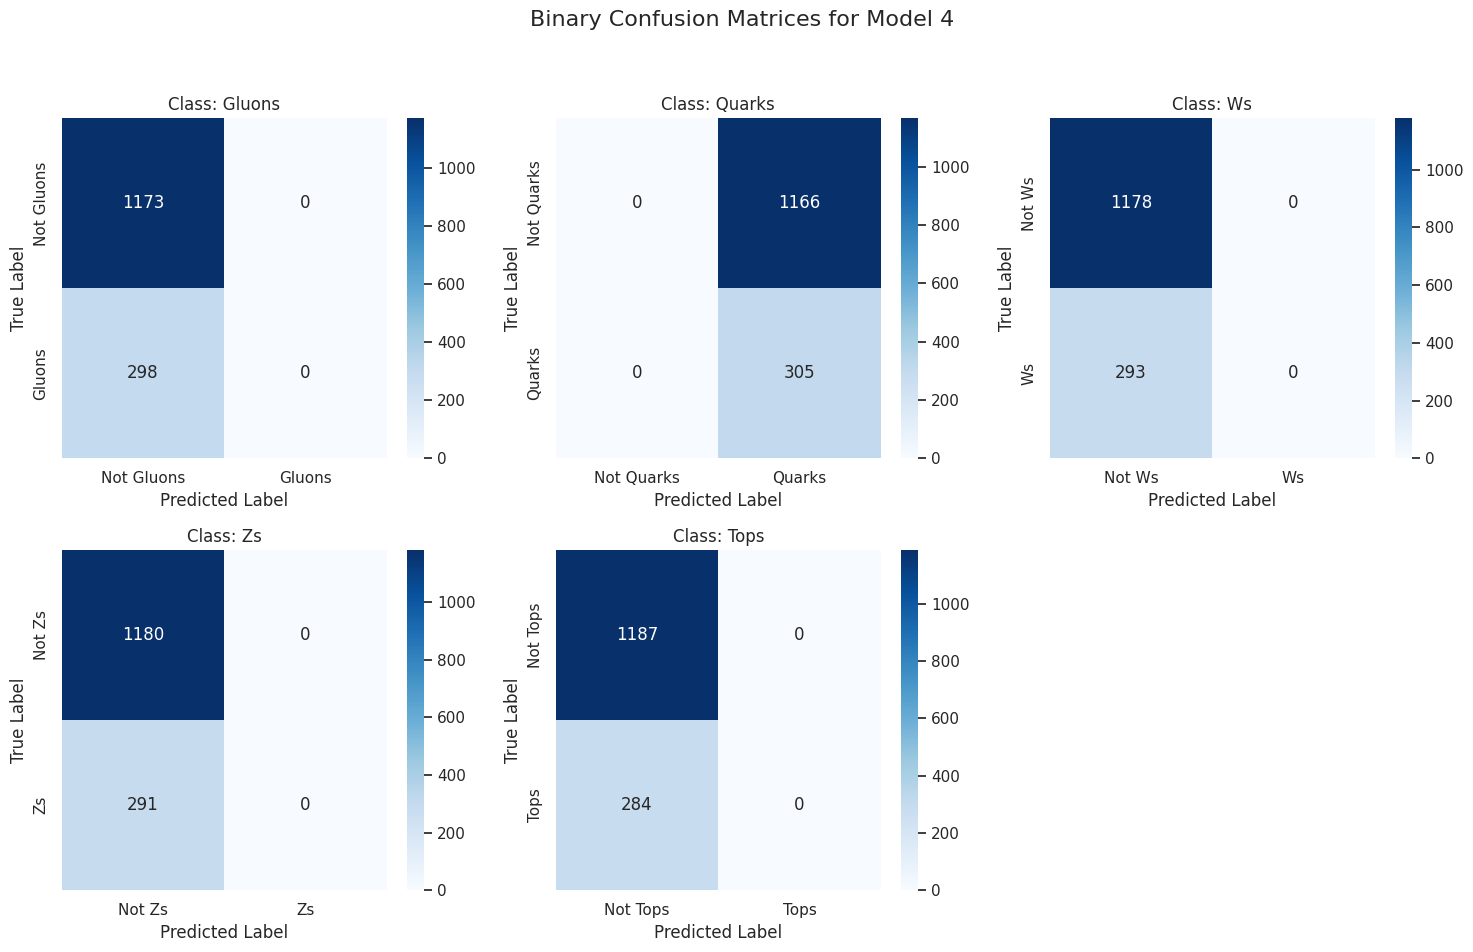

46/46 [==============================] - 1s 14ms/step


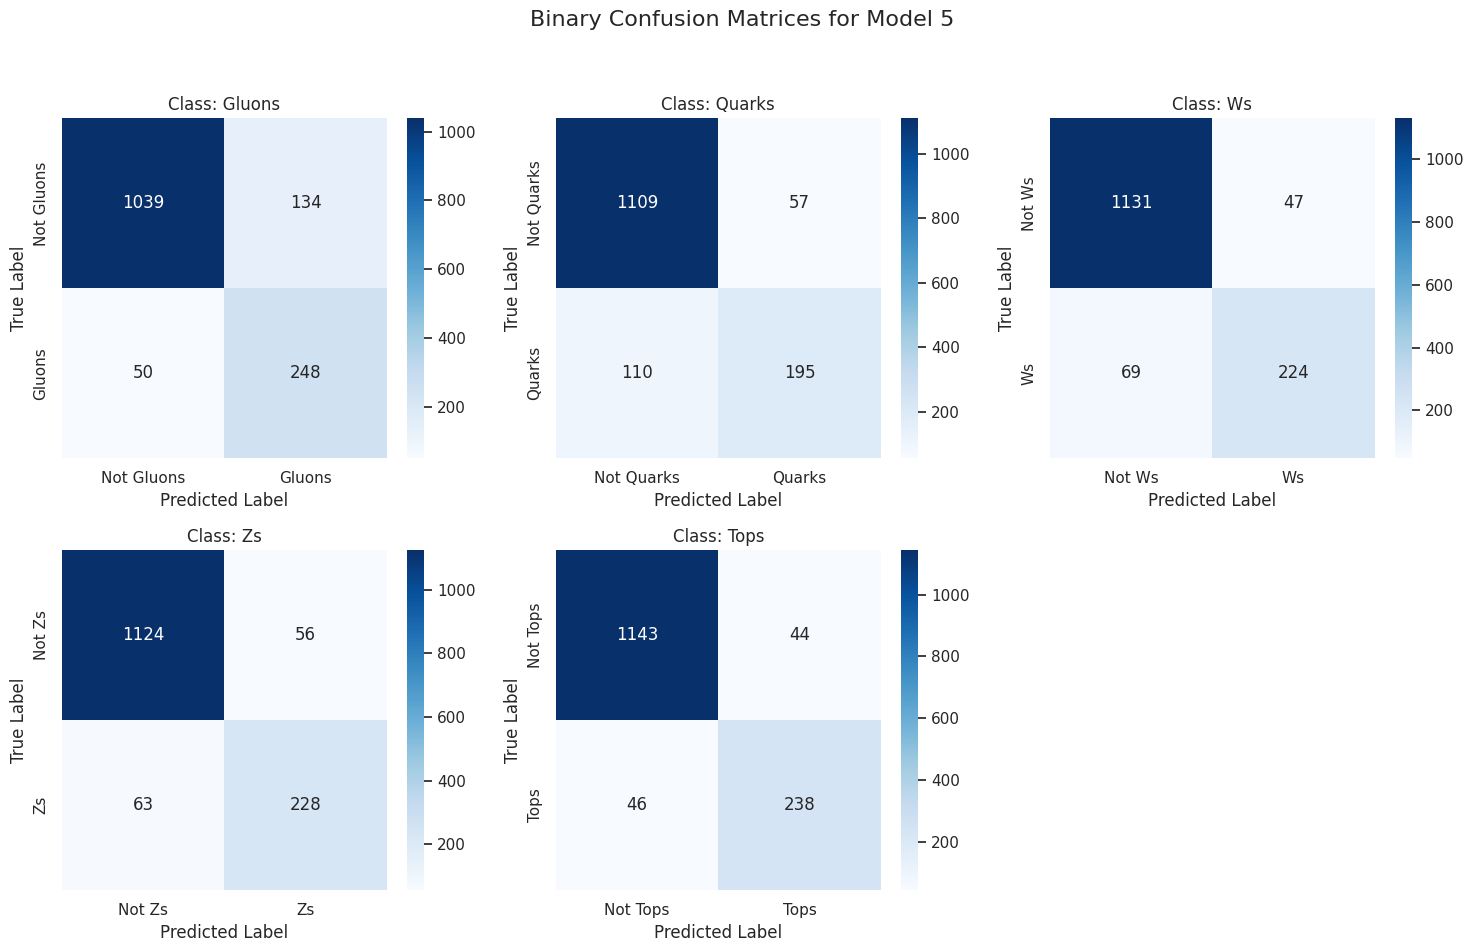

In [47]:
plot_confusion_matrices([model1,model2,model3,model4,model5,],
                        class_names=class_names,
                        data= (X_test_transformed, y_test_transformed) ,
                        each = True)

46/46 [==============================] - 0s 4ms/step


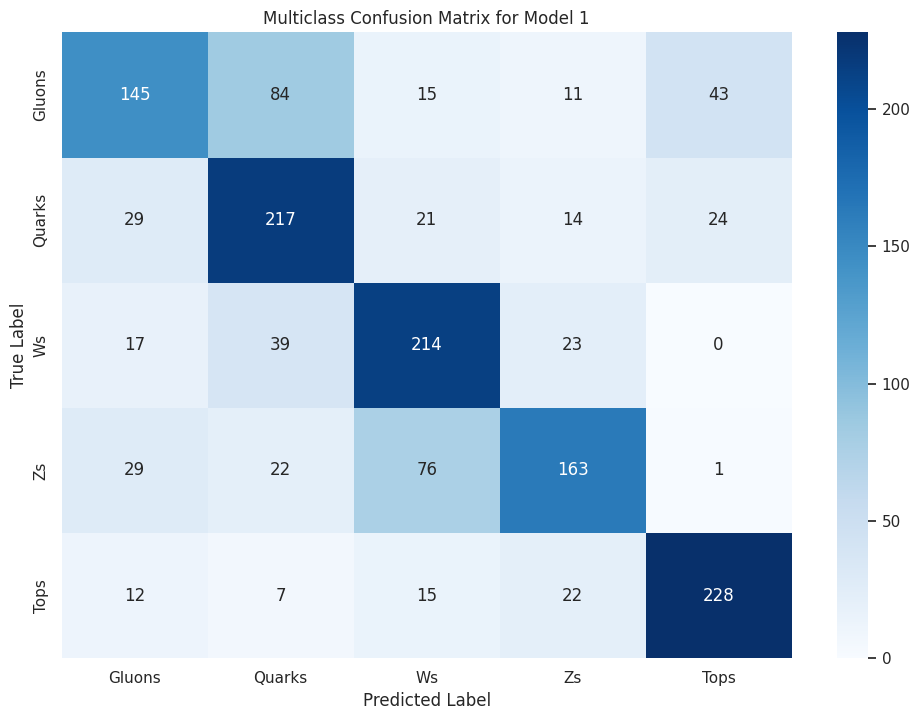

In [52]:
plot_confusion_matrices([model3],
                        class_names=class_names,
                        data= (X_test_transformed, y_test_transformed) ,)
                        #each = True)

46/46 [==============================] - 0s 4ms/step


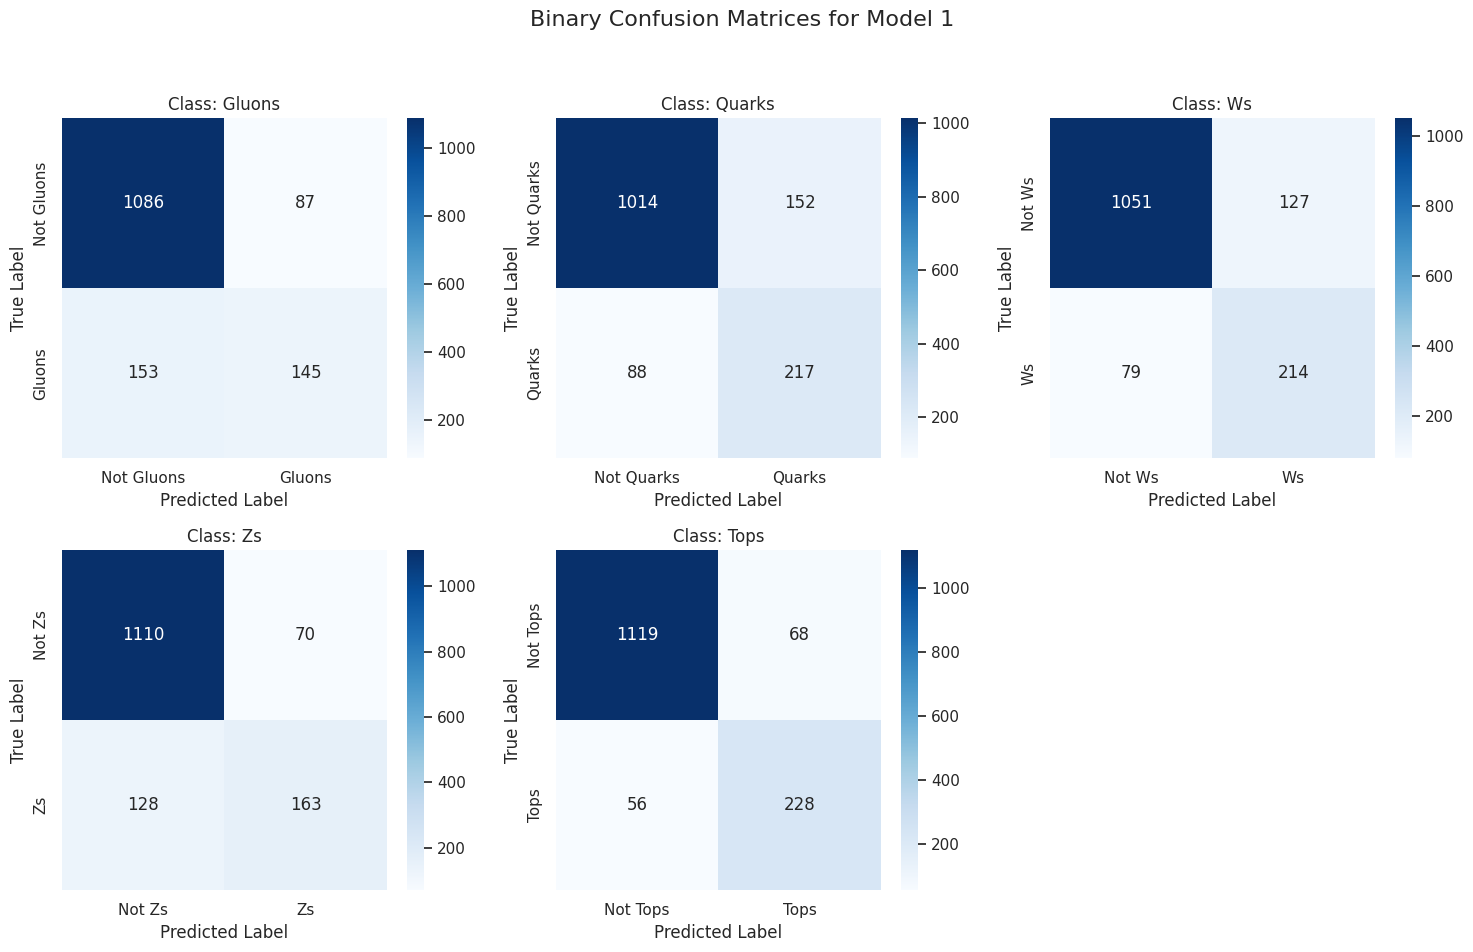

In [49]:
plot_confusion_matrices([model3],
                        class_names=class_names,
                        data= (X_test_transformed, y_test_transformed),
                        each = True)

46/46 [==============================] - 1s 13ms/step


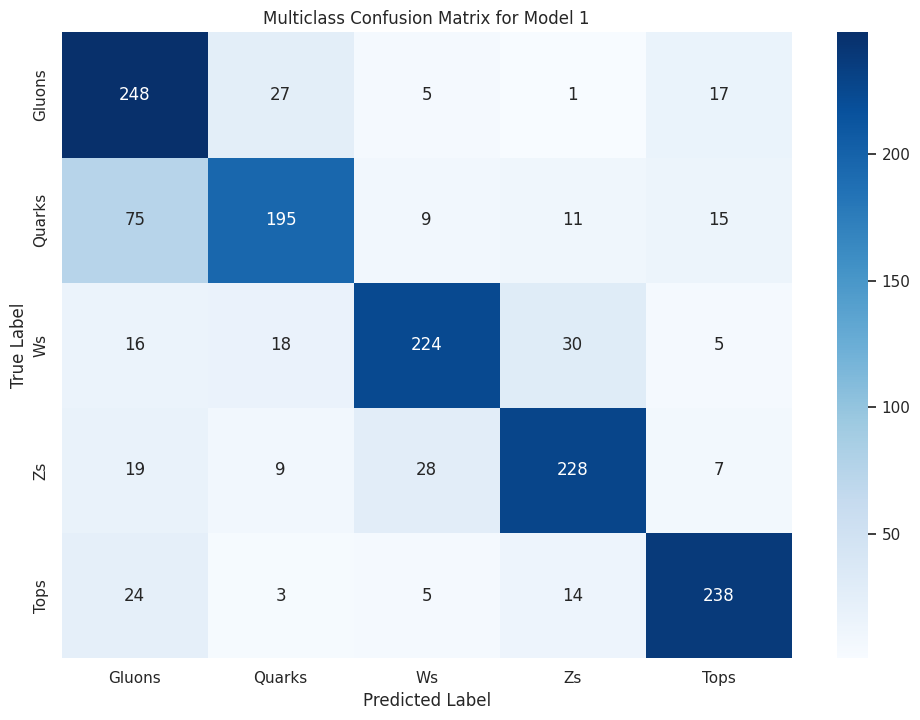

In [53]:
plot_confusion_matrices([model5],
                        class_names=class_names,
                        data= (X_test_transformed, y_test_transformed) ,)
                        #each = True)

46/46 [==============================] - 1s 14ms/step


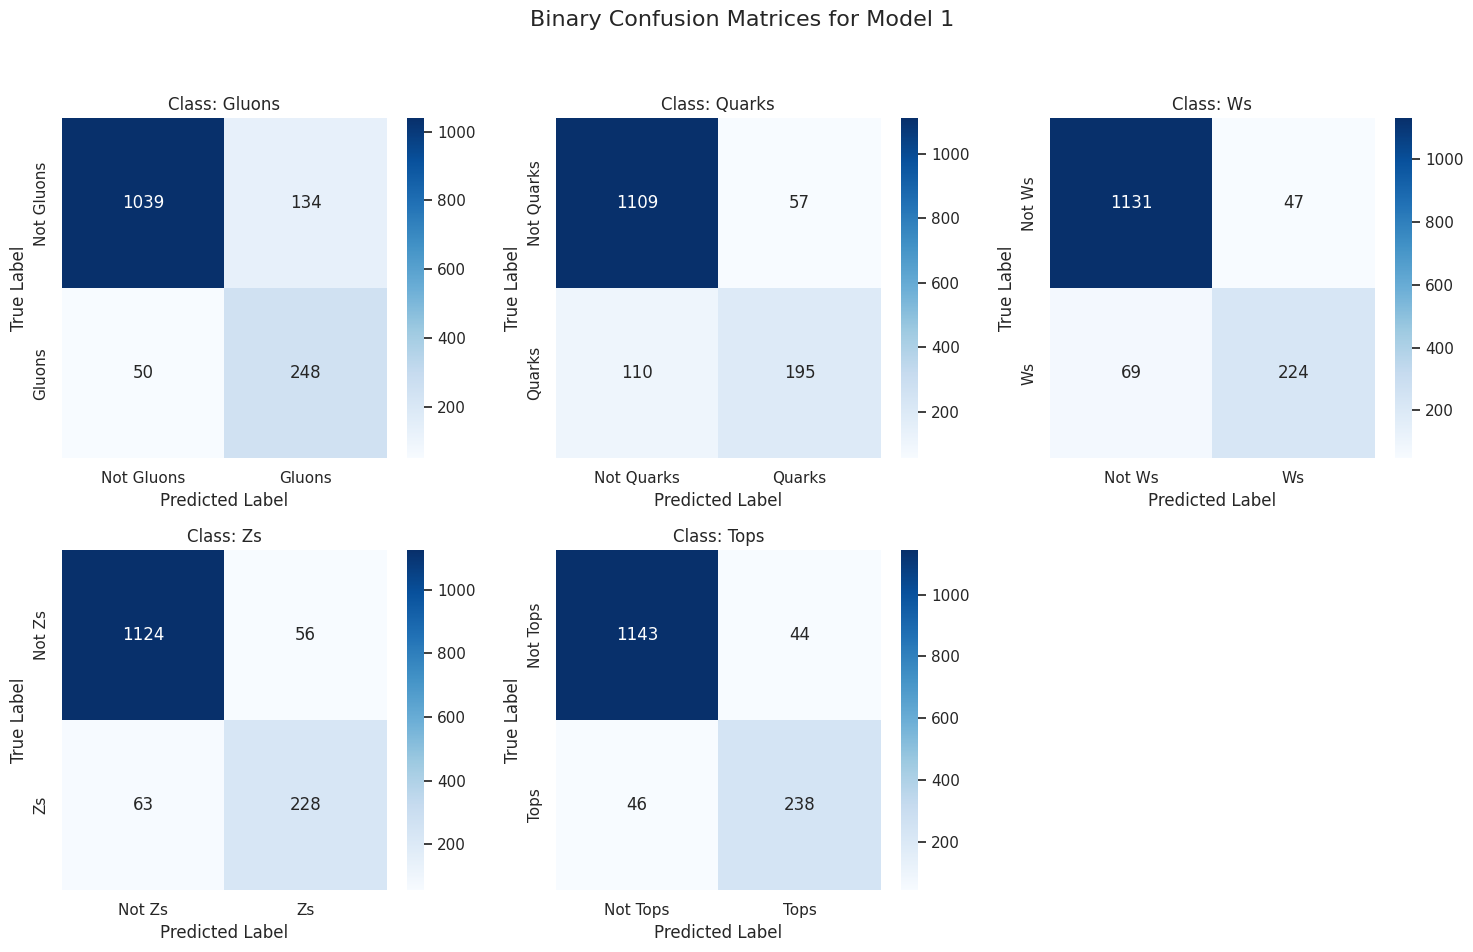

In [51]:
plot_confusion_matrices([model5],
                        class_names=class_names,
                        data= (X_test_transformed, y_test_transformed) ,
                      each = True)